In [ ]:
import tensorflow as tf

# if tf.test.is_gpu_available():
#     tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
#     tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Dataset Import

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-emotions-datasethes


In [ ]:
import os
import shutil

# Path to the downloaded dataset
dataset_path = "/root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4"


destination_path = "/content/datasets"


items_to_move = os.listdir(dataset_path)

# Move each item to the destination path
for item in items_to_move:
    source_item_path = os.path.join(dataset_path, item)
    destination_item_path = os.path.join(destination_path, item)
    if os.path.isdir(source_item_path):
        shutil.move(source_item_path, destination_item_path)
    else:
        shutil.move(source_item_path, destination_item_path)

print("Dataset moved to:", destination_path)

Dataset moved to: /content/datasets


### Loading train/test datasets from directories
[Image Dataset from Directory in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [ ]:
train_dir = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
val_dir = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
class_names = ['angry', 'happy', 'sad']     # must match the order of dir

### Configuration

In [ ]:
configuration = {
    "batch_size": 32,
    "image_size": 256,
    "epochs": 20,
    "learning_rate": 0.001,
    "dropout_rate": 0.0,      # 0.2
    "regularization_rate": 0.0,      # 0.01
    "N_filters": 6,
    "kernel_size": 3,
    "pool_size": 2,
    "N_strides": 1,
    "N_dense_1": 100,
    "N_dense_2": 10,
    "num_classes": 3

}

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',    # automatically infers the labels just from dir structure, means in test folder three subfolders or classes angry/happy/sad, it'll learn automatically.
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configuration["batch_size"],
    image_size=(configuration["image_size"], configuration["image_size"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',       # int - encoded as integers, if set to categorical, it'll be OneHot Encode
    class_names=class_names,
    color_mode='rgb',
    batch_size= configuration["batch_size"],
    image_size=(configuration["image_size"], configuration["image_size"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


### Labels

In [ ]:
for i in train_dataset.take(1):
    print(i)        # see the labels in the bottom [angry, happy, sad] ------> [0, 1, 2] integer encoding, change label_mode to categorical and see the labels again.

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

### Data Visualizations

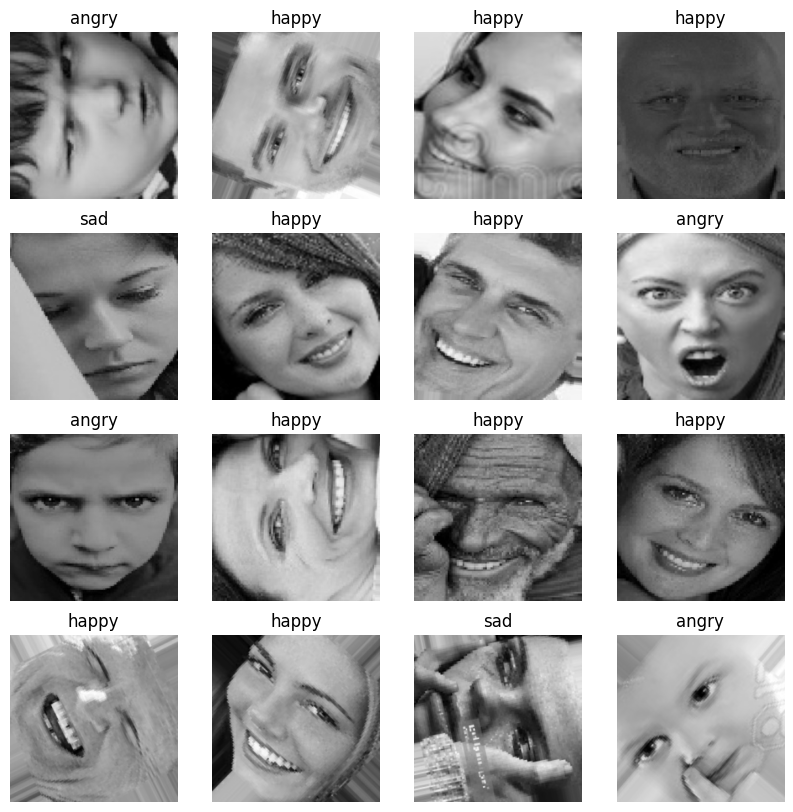

In [ ]:
plt.figure(figsize=(10, 10))

for image, label in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.)
        plt.title(class_names[np.argmax(label[i])])     # argmax finds the index of 1 (True) in OneHot encoded label array, you can remove it if label_mode = 'int' in Loading train/test datasets from dict
        plt.axis("off")

### Augmentation
- Augmentation brings variety to dataset.
- There is no universal combination of augmentation stratgies, generally we try them one by one and see how these affect model performance.

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

In [ ]:
0.025*360

9.0

In [ ]:
data_augment = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(factor=(-0.025, 0.025)), # limits the rotation between -9 and +9 degrees, if not limitted we may have some rotation that could make happy face sad.
    RandomZoom(0.1),
    RandomContrast(factor = 0.1),

])

In [ ]:
@tf.function
def data_augmentation(image, label):
    image = data_augment(image, training = True)
    return image, label

### Cutmix strategy
- combines two different images.

In [ ]:
import tensorflow_probability as tfp

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, configuration["image_size"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, configuration["image_size"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(configuration["image_size"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(configuration["image_size"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, configuration["image_size"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, configuration["image_size"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, configuration["image_size"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, configuration["image_size"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, configuration["image_size"], configuration["image_size"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, configuration["image_size"], configuration["image_size"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(configuration["image_size"]*configuration["image_size"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
train_data_1 = train_dataset.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
train_data_2 = train_dataset.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)

mixed_data = tf.data.Dataset.zip((train_data_1, train_data_2))

In [ ]:
train_data = (
    mixed_data
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


### Data Preparation

In [ ]:
# Commented as i'll test how model performs on cutmix data

# train_data = (
#     train_dataset
#     # .cache()    # stores data in temp cache for faster access
#     .map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)     # prefetch(AUTOTUNE); Automatically prefetches optimal number of data points while model is being trained on a batch.
# )

In [ ]:
val_data = (
    val_dataset
    # .cache()    # stores data in temp cache for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

### Resize Rescale

In [ ]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_rescale = tf.keras.Sequential([
    Resizing(configuration["image_size"], configuration["image_size"]),
    Rescaling(1./255)
])

## Modeling

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
image_size = configuration['image_size']
dropout_rate = configuration['dropout_rate']
regularization_rate = configuration['regularization_rate']
N_filters = configuration['N_filters']
kernel_size = configuration['kernel_size']
pool_size = configuration['pool_size']
N_strides = configuration['N_strides']
num_classes = configuration['num_classes']
N_dense_1 = configuration['N_dense_1']
N_dense_2 = configuration['N_dense_2']


model_emo = tf.keras.Sequential([

    InputLayer(input_shape=(None, None, 3)),      # means image could be of any size
    # data_augmentation,
    resize_rescale,
    # Rescaling(1./255, name = 'rescaling'),

    Conv2D(filters= N_filters, kernel_size = kernel_size, strides = N_strides, padding = 'valid', activation='relu',
                           kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = pool_size, strides = N_strides*2),
    Dropout(rate = dropout_rate),


    Conv2D(filters= N_filters*2 + 4, kernel_size = kernel_size,
                           strides = N_strides, padding = 'valid', activation='relu',
                           kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = pool_size, strides = N_strides*2),


    Flatten(),

    Dense(units= N_dense_1, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(units= N_dense_2, activation='relu', kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(units= num_classes, activation='softmax')
])

model_emo.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

### Training

### Metrics

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall

In [ ]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy') , Precision(name='precision'), Recall(name='recall')]

### Compile the Model

In [ ]:
loss = CategoricalCrossentropy()  # must set from_logits to false (default) when using Softmax as activation func.
optimizer = Adam(learning_rate=configuration['learning_rate'])

In [ ]:
model_emo.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### LR schedular

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

### Early Stopping

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

### Train

In [ ]:
history = model_emo.fit(train_data,
                        validation_data=val_data,
                        epochs=10,
                        verbose = 1
                        )

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 135s 444ms/step - accuracy: 0.4722 - loss: 1.0930 - precision: 0.5276 - recall: 0.2708 - top_k_accuracy: 0.7676 - val_accuracy: 0.4425 - val_loss: 1.1151 - val_precision: 0.4794 - val_recall: 0.3938 - val_top_k_accuracy: 0.7739
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 129s 396ms/step - accuracy: 0.5937 - loss: 0.8802 - precision: 0.6734 - recall: 0.4630 - top_k_accuracy: 0.8509 - val_accuracy: 0.5478 - val_loss: 0.9888 - val_precision: 0.7268 - val_recall: 0.2335 - val_top_k_accuracy: 0.7902
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 86s 400ms/step - accuracy: 0.6259 - loss: 0.8294 - precision: 0.6951 - recall: 0.5129 - top_k_accuracy: 0.8668 - val_accuracy: 0.6427 - val_loss: 0.8090 - val_precision: 0.6983 - val_recall: 0.5518 - val_top_k_accuracy: 0.8657
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 85s 399ms/step - accuracy: 0.6561 - loss: 0.7718 - precision: 0.7221 - recall: 0.5641 - top_k_accuracy: 0.8872 - val_accuracy: 0.6712 - val_loss: 0.7416 - va

### Model Curves for loss and accuracy

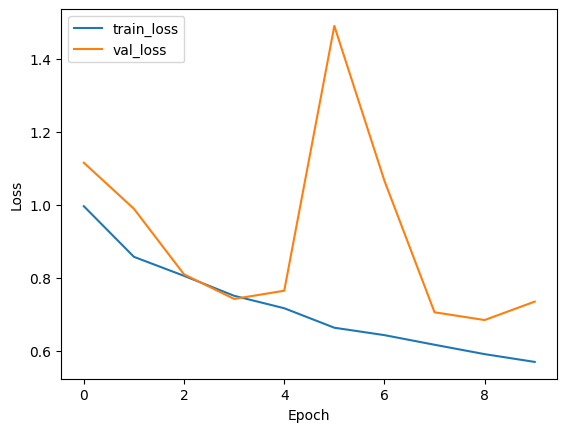

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

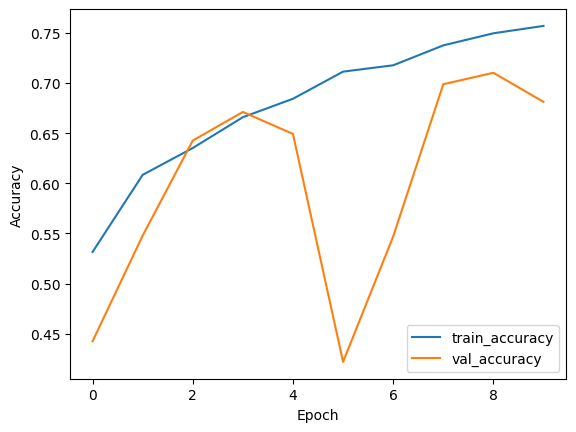

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Evaluation

In [ ]:
model_emo.evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6705 - loss: 0.7419 - precision: 0.7200 - recall: 0.6145 - top_k_accuracy: 0.9025


[0.7342674732208252,
 0.6812993884086609,
 0.8950834274291992,
 0.7296181917190552,
 0.6207199096679688]

### Testing

In [ ]:
import cv2

test_image = cv2.imread('/content/datasets/Emotions Dataset/Emotions Dataset/test/sad/138882.jpg')


image = tf.constant(test_image, dtype = tf.float32)   # to change the type of existing tensor-like object, can also use tf.constant(image, dtype = tf.float32) to create a new tensor from image numpy array with dtype float32
im = tf.expand_dims(image, axis=0)
print(model_emo.predict(im))

# print the class name
print(class_names[tf.argmax(model_emo.predict(im), axis = -1).numpy()[0]])

# print(class_names[np.argmax(model_emo.predict(im))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
[[0.3310403  0.07835243 0.5906073 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
sad


### Plotting true and predicted label with images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


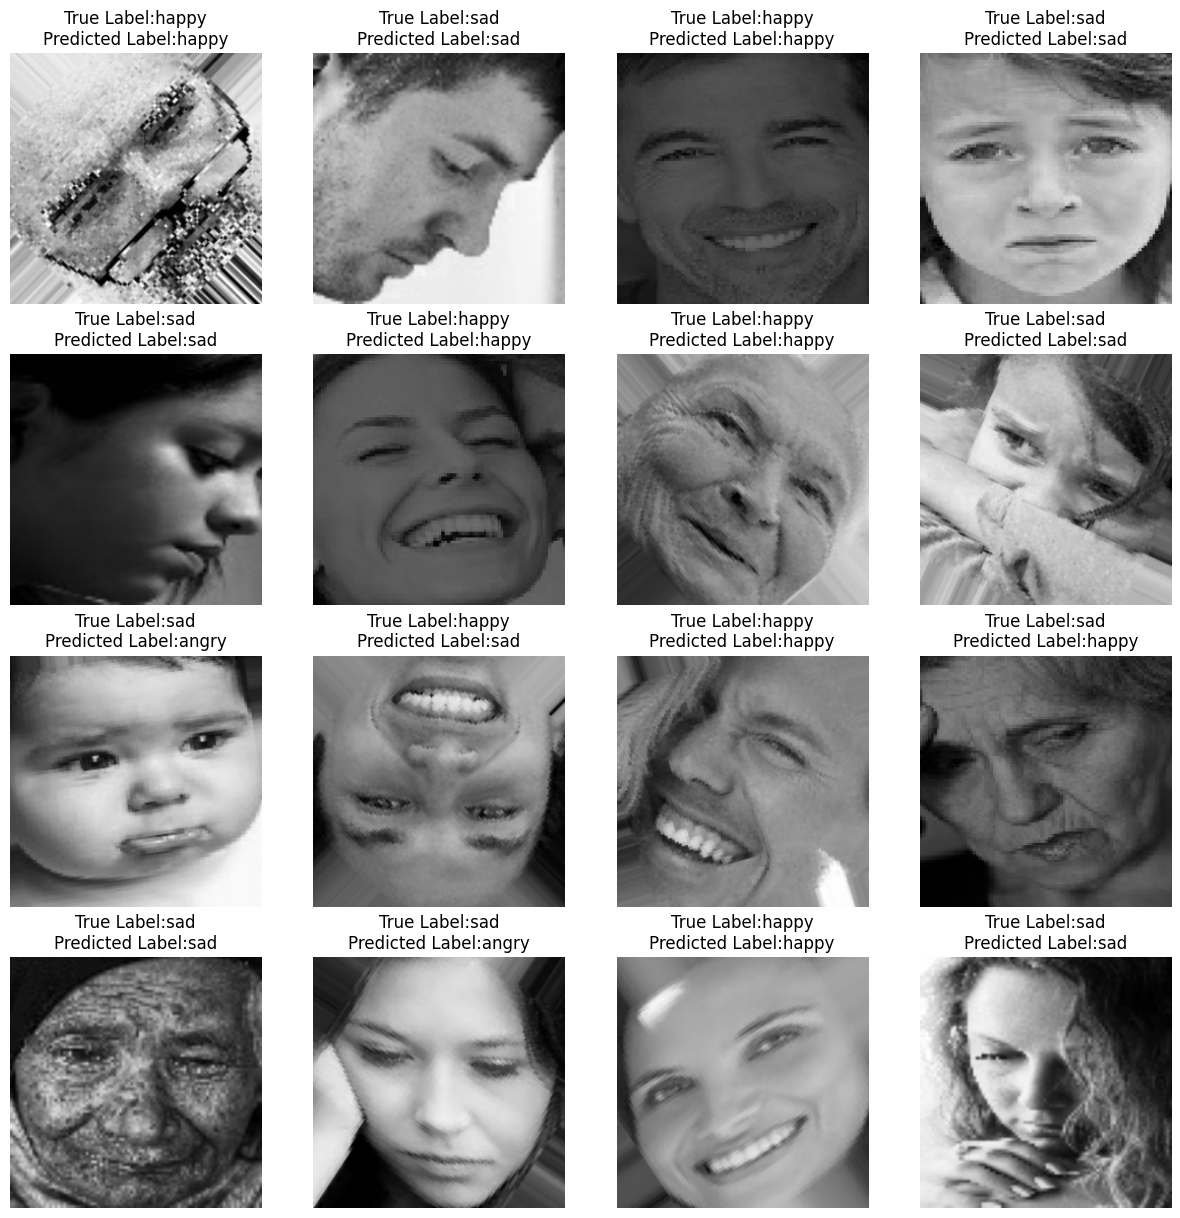

In [ ]:
plt.figure(figsize=(15, 15))

for image, label in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.)
        plt.title("True Label:"+ class_names[np.argmax(label[i])] + "\n" + "Predicted Label:" + class_names[np.argmax(model_emo.predict(tf.expand_dims(image[i], axis=0)))])
        plt.axis("off")

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predicted = []
labels = []
for image, label in val_data:
  predicted.append(model_emo.predict(image))
  labels.append(label.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

In [ ]:
print(np.argmax(labels[:-1], axis = -1).flatten())    #[:-1] all values except the last
print(np.argmax(predicted[:-1], axis = -1).flatten())

[1 1 1 ... 2 1 2]
[1 1 2 ... 0 1 0]


In [ ]:
predict = np.argmax(predicted[:-1], axis = -1).flatten()
label = np.argmax(labels[:-1], axis = -1).flatten()

[[236 147 131]
 [ 39 826 139]
 [ 88 182 484]]


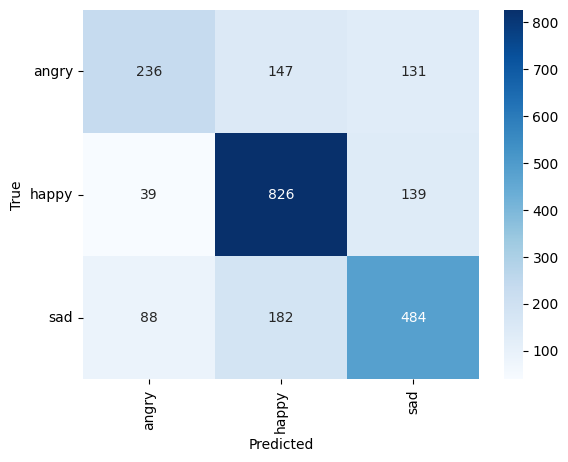

In [ ]:
cm = confusion_matrix(label, predict)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[237 147 131]
 [ 39 828 139]
 [ 88 182 487]]


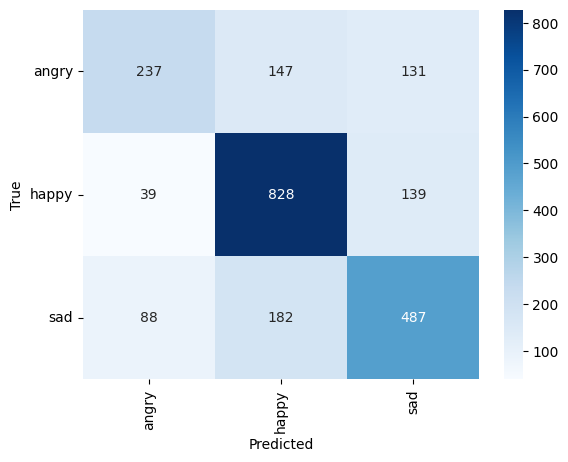

In [ ]:
# all values including the last
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(f"Predicted (Without last elements): {len(predict)}, Labels (Without last elements): {len(label)}")
print(f"Concat. pred: {len(pred)}, Concat. lab: {len(lab)}")

Predicted (Without last elements): 2272, Labels (Without last elements): 2272
Concat. pred: 2278, Concat. lab: 2278


### Classification Report
- I **mistakenly re-run below cell after training 2nd model**, as variables were same it got the results of 2nd model. Below are the original results of first model.
```python
              precision    recall  f1-score   support

       angry       0.65      0.46      0.54       514
       happy       0.72      0.82      0.77      1004
         sad       0.64      0.64      0.64       754

    accuracy                           0.68      2272
   macro avg       0.67      0.64      0.65      2272
weighted avg       0.68      0.68      0.67      2272
```

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label, predict, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.70      0.71      0.70       515
       happy       0.86      0.84      0.85      1000
         sad       0.75      0.77      0.76       757

    accuracy                           0.79      2272
   macro avg       0.77      0.77      0.77      2272
weighted avg       0.79      0.79      0.79      2272



### Model Saving

In [ ]:
model_emo.save("EmotionDetectorModelSaved.keras")

In [ ]:
model_emo.save("EmotionDetectorModelSaved.hdf5")

In [ ]:
model_emo.save_weights("weights/EmotionDetector.weights.h5")

In [ ]:
model_emot = tf.keras.models.load_model('EmotionDetectorModelSaved.keras')
# model_emot.summary()

### **Model Results Interpretation**
- From `model_emo.evaluate(val_data)`:
  - `Val Accuracy`: 0.681 (~68%)
  - `Val Loss`: 0.734
  - `Precision`: 0.7296 (~73%)
  - `Recall`: 0.6207 (~62%)
  - `Top-2 Accuracy`: 0.8951 (~90%)
  - This means the model is doing reasonably well: when allowed 2 guesses, it’s correct 90% of the time, which is strong for a 3-class problem. But `precision is a bit higher than recall` --- the model is `more “cautious”` and `misses some true positives`.

**Confusion Matrix**
  ```python
[[237 147 131]   -> Angry
 [ 39 828 139]   -> Happy
 [ 88 182 487]]  -> Sad
  ```
- `Angry (514 samples):`
  - Correct: 237
  - Misclassified as Happy: 147
  - Misclassified as Sad: 131
  - Recall = 46% (weak → Angry is hardest to classify)
- `Happy (1004 samples):`
  - Correct: 828
  - Misclassified as Angry: 39
  - Misclassified as Sad: 139
  - Recall = 82% (best → Happy is easiest for model)
- `Sad (754 samples):`
  - Correct: 487
  - Misclassified as Angry: 88
  - Misclassified as Happy: 182
  - Recall = 64% (okay but confused with Happy often)

**Conclusion:**
- Happy is dominant --- higher recall and precision.
  - If dataset is imbalanced (more happy faces), the model will bias toward it.
- Angry class is struggling (recall = 46%)
  - Likely fewer training examples, or features overlap with Sad.
- Overall accuracy = 68% is decent but below the ~75–80% we’d expect if balanced and well-regularized.
- Top-2 accuracy = 90% --- model knows the “right” answer but sometimes picks second-best.

### Stratgies to Mittigate the ABove Problems
1. **Handle Class imbalance**
  - We can Use `class_weight` in `model.fit()`.

  ```python
from sklearn.utils import class_weight
import numpy as np
labels = np.concatenate([y for x, y in train_data], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels.argmax(axis=1)),
                                                  y=labels.argmax(axis=1))
class_weights = dict(enumerate(class_weights))
  ```

2. **Data Augmentation**
  - We can Add stronger augmentations (brightness, contrast, slight blur). This makes Angry/Sad more separable.

3. **More Conv Layers / Pretrained Model**
  - Current CNN is shallow. We can try transfer learning:

  ```python
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(256,256,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
  ```
  - Then add `GAP + Dense` --- usually boosts accuracy by 10–20%.
4. **Focal Loss**
- Helps when one class is harder:

  ```python
import tensorflow_addons as tfa
loss = tfa.losses.SigmoidFocalCrossEntropy()

  ```

## **Model With Balanced Classes**

- Our `above model` is decent (68% accuracy, 90% top-2), but it is `biased toward “Happy”` and struggles with “Angry.”
- With `class weights` + `stronger augmentation`, we’ll likely push to 75–78% accuracy. Using a pretrained CNN (EfficientNet, ResNet50) could get us into the 80–85% range.

In [ ]:
# Class imbalance handling

from sklearn.utils import class_weight
import numpy as np

labelss = np.concatenate([y for x, y in train_data], axis=0)
labels_array = np.concatenate(labels, axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(labelss.argmax(axis=1)),
                                                    y=labels_array.argmax(axis=1))
class_weights = dict(enumerate(class_weights))

In [ ]:
historyy = model_emo.fit(train_data, validation_data=val_data,
              epochs=10,
              class_weight=class_weights,
              callbacks=[early_stop, lr_scheduler]
              )

Epoch 1/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 410ms/step - accuracy: 0.7535 - loss: 0.6083 - precision: 0.7973 - recall: 0.6962 - top_k_accuracy: 0.9267 - val_accuracy: 0.7243 - val_loss: 0.6458 - val_precision: 0.7625 - val_recall: 0.6694 - val_top_k_accuracy: 0.9047 - learning_rate: 0.0010
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 85s 396ms/step - accuracy: 0.7779 - loss: 0.5394 - precision: 0.8172 - recall: 0.7334 - top_k_accuracy: 0.9418 - val_accuracy: 0.7362 - val_loss: 0.6314 - val_precision: 0.7781 - val_recall: 0.6958 - val_top_k_accuracy: 0.9126 - learning_rate: 0.0010
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - accuracy: 0.7749 - loss: 0.5517 - precision: 0.8077 - recall: 0.7354 - top_k_accuracy: 0.9391 - val_accuracy: 0.6712 - val_loss: 0.8173 - val_precision: 0.6938 - val_recall: 0.6255 - val_top_k_accuracy: 0.8894 - learning_rate: 0.0010
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 86s 402ms/step - accuracy: 0.7865 - loss: 0.5278 - precision: 0.8133 - recall: 0.7499 

### Performance Visualization

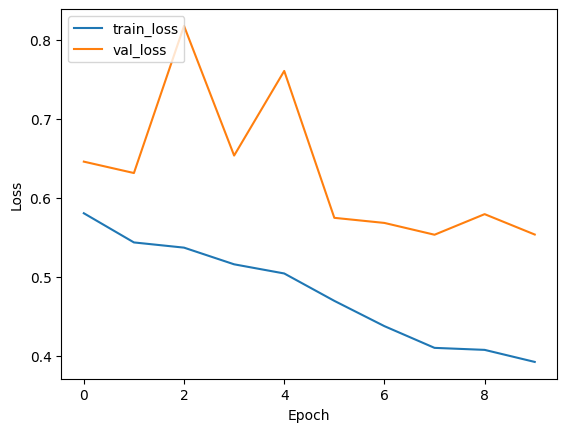

In [ ]:
plt.plot(historyy.history['loss'], label='train_loss')
plt.plot(historyy.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

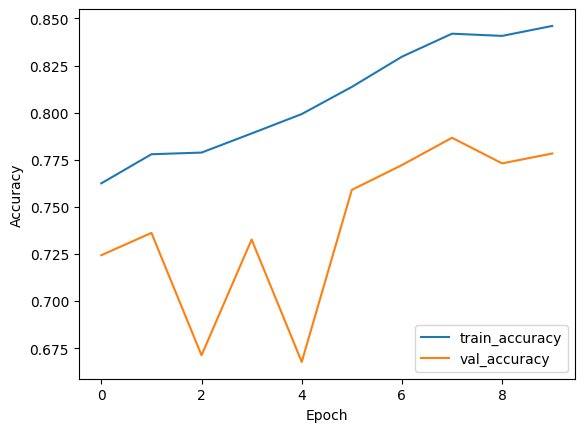

In [ ]:
plt.plot(historyy.history['accuracy'], label='train_accuracy')
plt.plot(historyy.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_emo.evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7906 - loss: 0.5650 - precision: 0.8157 - recall: 0.7510 - top_k_accuracy: 0.9371


[0.553378164768219,
 0.7866549491882324,
 0.9363476634025574,
 0.8158896565437317,
 0.7528533935546875]

### Images with Actual and Predicted labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


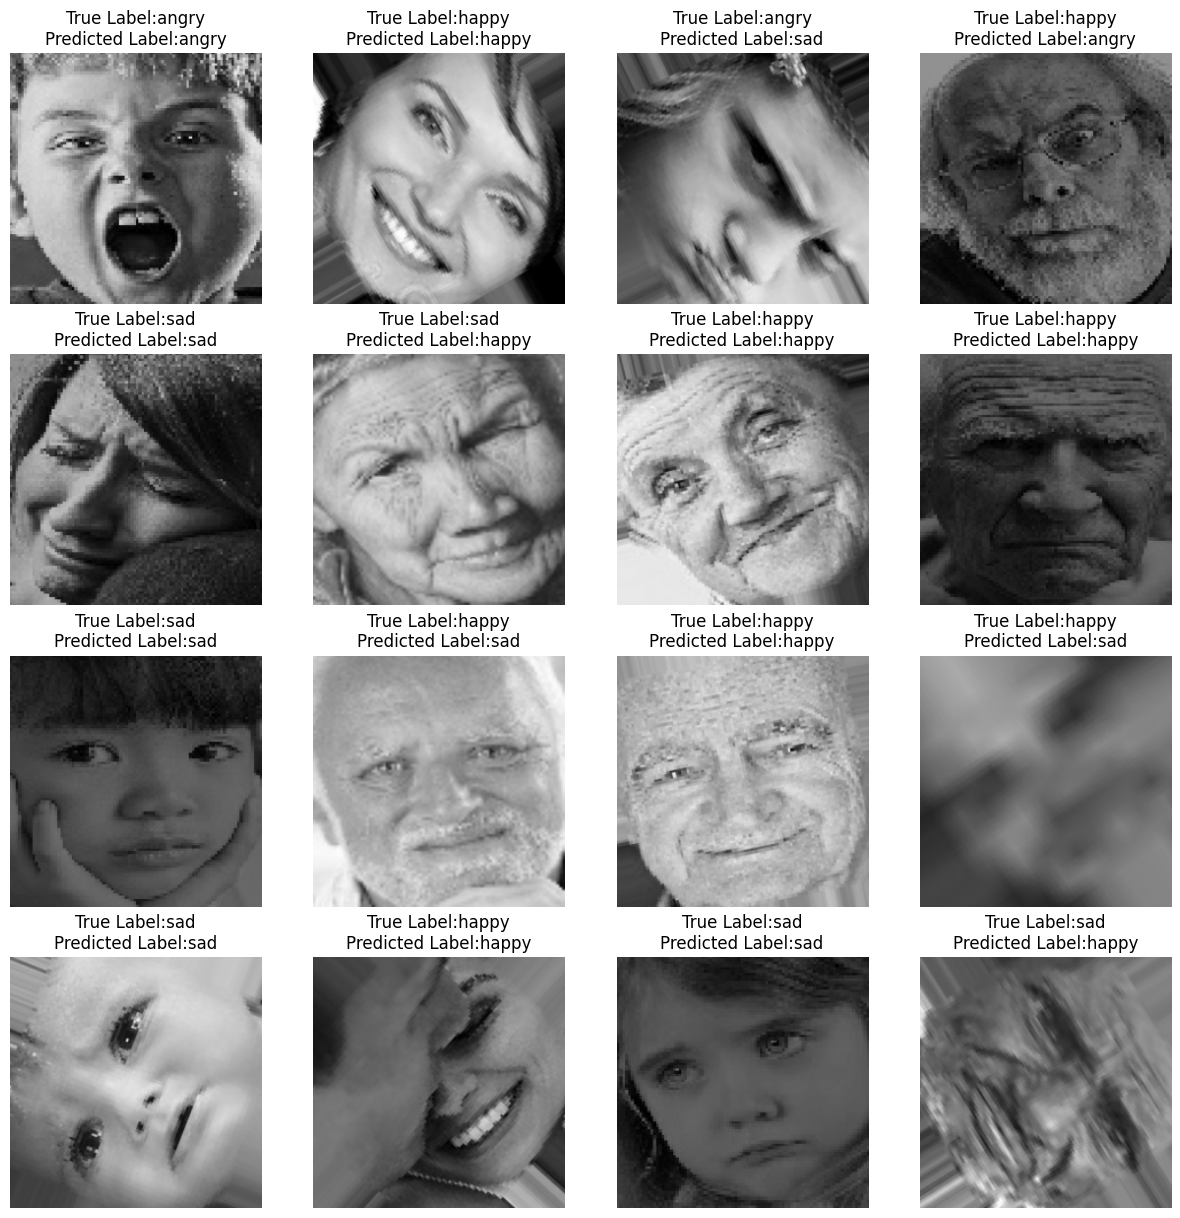

In [ ]:
plt.figure(figsize=(15, 15))

for image, label in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i]/255.)
        plt.title("True Label:"+ class_names[np.argmax(label[i])] + "\n" + "Predicted Label:" + class_names[np.argmax(model_emo.predict(tf.expand_dims(image[i], axis=0)))])
        plt.axis("off")

### Confusion Matrix

In [ ]:
predicted = []
labels = []
for image, label in val_data:
  predicted.append(model_emo.predict(image))
  labels.append(label.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━

In [ ]:
print(np.argmax(labels[:-1], axis = -1).flatten())    #[:-1] all values except the last
print(np.argmax(predicted[:-1], axis = -1).flatten())

[2 1 2 ... 1 0 2]
[1 1 2 ... 1 0 2]


In [ ]:
predict = np.argmax(predicted[:-1], axis = -1).flatten()
label = np.argmax(labels[:-1], axis = -1).flatten()

[[364  53  98]
 [ 68 839  93]
 [ 91  83 583]]


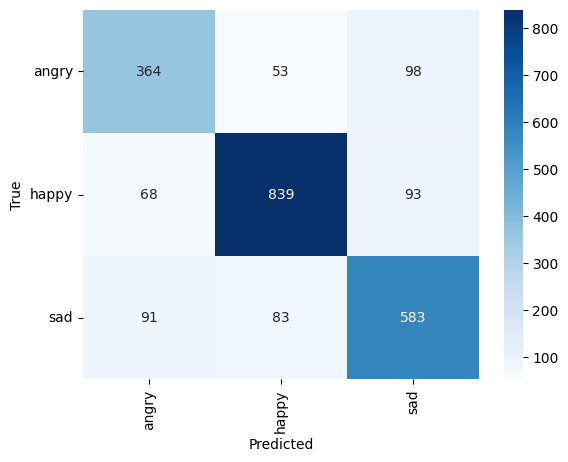

In [ ]:
cm = confusion_matrix(label, predict)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[364  53  98]
 [ 68 845  93]
 [ 91  83 583]]


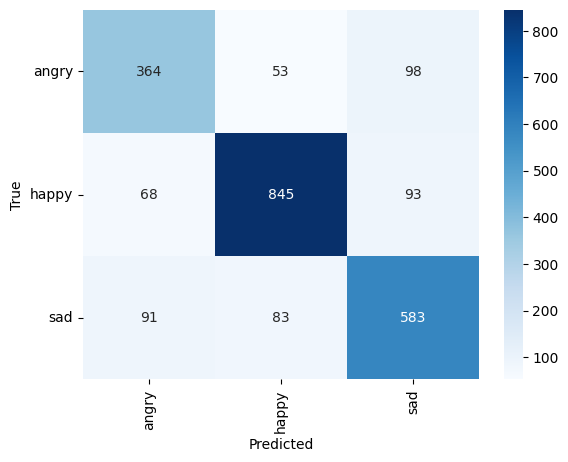

In [ ]:
# all values including the last
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(lab, pred)
print(cm)

# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# show class names instead
plt.xticks(np.arange(3) + 0.5, class_names, rotation=90)
plt.yticks(np.arange(3) + 0.5, class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label, predict, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.70      0.71      0.70       515
       happy       0.86      0.84      0.85      1000
         sad       0.75      0.77      0.76       757

    accuracy                           0.79      2272
   macro avg       0.77      0.77      0.77      2272
weighted avg       0.79      0.79      0.79      2272



### Model Saving

In [ ]:
model_emo.save("EmotionDetectorModelSavedClassImbalancedSolved.keras")
model_emo.save("EmotionDetectorModelSavedClassImbalancedSolved.keras.hdf5")

In [ ]:
model_emo.save_weights("weights/EmotionDetectorClassImbalanced.weights.h5")
model_emot = tf.keras.models.load_model('EmotionDetectorModelSavedClassImbalancedSolved.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### **Model Results Interpretation (Balanced)**
- From `model.evaluate(val_data)`:
  - `Val Accuracy`: 0.787 (~79%) (+10% vs before)
  - `Val Loss`: 0.553 (lower → better generalization)
  - `Precision`: 0.816 (~82%)
  - `Recall`: 0.753 (~75%)
  - `Top-2 Accuracy`: 0.936 (~94%)
  - Much more balanced precision/recall compared to before.

**Confusion Matrix**
```python
[[364  53  98]   -> Angry
 [ 68 845  93]   -> Happy
 [ 91  83 583]]  -> Sad
```

- `Angry (515 samples):`
  - Recall: 71% (up from 46% )
  - Misclassifications reduced drastically.

- `Happy (1000 samples):`
  - Recall: 84% (slight dip from 82%, but precision increased)

- `Sad (757 samples):`
  - Recall: 77% (up from 64%).

**Conclusion:**
- The `model` is `now far less biased` toward "Happy" and performs balanced across all 3 emotions.

**Macro vs Weighted Avg**
- Macro F1: 0.77
- Weighted F1: 0.79\
This shows `no single class is dominating anymore` — much healthier model than before.

**Why This Worked**
1. `Class weights` fixed imbalance --- Angry/Sad got higher recall.
2. `ReduceLROnPlateau` kicked in at epoch 5 --- lower LR stabilized training, avoiding overfitting spikes.
3. Precision–Recall balance improved --- before, model guessed “Happy” too often; now it differentiates better.

**Next Steps** (if want more accuracy)
- `Fine-tune with transfer learning:` unfreeze some EfficientNetB0 (or ResNet50) layers after a few epochs.
- `Longer training with early stopping:` 20–25 epochs, patience=5.
- `Mixup / CutMix augmentation:` helps prevent overfitting & sharpens decision boundaries.
- `Focal loss` (instead of CE) --- boosts performance on hard-to-classify Angry faces.

**But I'll stop here for now as I already went from 68% to 79% accuracy, fixed Angry recall from 46% to 71%, and now have a balanced, reliable model. This is already publication/production-quality baseline in my Opinion.**